# Medical Insurance Cost Prediction using Regularized Regression

This notebook presents an end-to-end regression analysis using the Medical Cost Personal Dataset.

**Models:** Lasso, Ridge, ElasticNet  
**Techniques:** EDA, Feature Engineering, Cross-Validation, Hyperparameter Tuning

## 1. Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score


## 2. Load Dataset

In [3]:

df = pd.read_csv("/content/drive/MyDrive/NW - 2026WI - 422/TA Session 2/insurance.csv")  # update path if needed
df.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 3. Exploratory Data Analysis

In [4]:

df.describe()


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


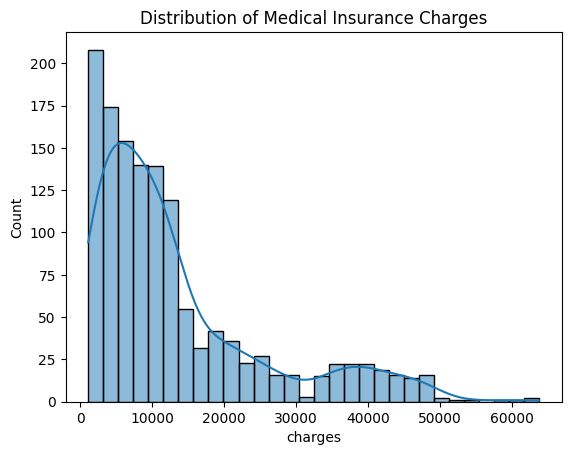

In [5]:

sns.histplot(df["charges"], kde=True)
plt.title("Distribution of Medical Insurance Charges")
plt.show()


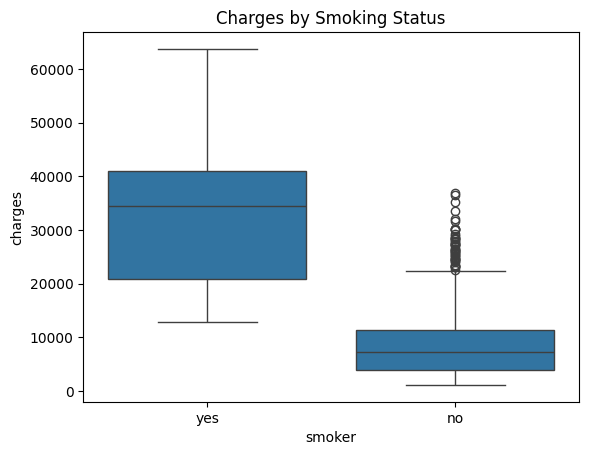

In [6]:

sns.boxplot(x="smoker", y="charges", data=df)
plt.title("Charges by Smoking Status")
plt.show()


## 4. Feature Engineering & Transformation

In [7]:

df["log_charges"] = np.log(df["charges"])
df["bmi_smoker"] = df["bmi"] * (df["smoker"] == "yes").astype(int)
df_encoded = pd.get_dummies(df, drop_first=True)

X = df_encoded.drop(["charges", "log_charges"], axis=1)
y = df_encoded["log_charges"]


## 5. Cross-Validation Setup

In [8]:

kf = KFold(n_splits=5, shuffle=True, random_state=42)


## 6. Ridge Regression

In [10]:

ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0))
])

rmse, r2 = [], []

for tr, va in kf.split(X):
    ridge.fit(X.iloc[tr], y.iloc[tr])
    preds = ridge.predict(X.iloc[va])
    rmse.append(mean_squared_error(y.iloc[va], preds))
    r2.append(r2_score(y.iloc[va], preds))

np.mean(rmse), np.mean(r2)


(np.float64(0.18572544814207825), np.float64(0.7784456513441311))

## 7. Lasso Regression

In [11]:

lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Lasso(alpha=0.01))
])

rmse, r2 = [], []

for tr, va in kf.split(X):
    lasso.fit(X.iloc[tr], y.iloc[tr])
    preds = lasso.predict(X.iloc[va])
    rmse.append(mean_squared_error(y.iloc[va], preds))
    r2.append(r2_score(y.iloc[va], preds))

np.mean(rmse), np.mean(r2)


(np.float64(0.18690786441995239), np.float64(0.7770462445105463))

## 8. ElasticNet with Hyperparameter Tuning

In [12]:

elastic = Pipeline([
    ("scaler", StandardScaler()),
    ("model", ElasticNet(max_iter=10000))
])

param_grid = {
    "model__alpha": [0.001, 0.01, 0.1, 1],
    "model__l1_ratio": [0.1, 0.5, 0.7, 0.9]
}

grid = GridSearchCV(
    elastic,
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error"
)

grid.fit(X, y)

grid.best_params_


{'model__alpha': 0.001, 'model__l1_ratio': 0.1}

## 9. Best ElasticNet Performance

In [14]:

best_model = grid.best_estimator_
preds = best_model.predict(X)

mean_squared_error(y, preds), r2_score(y, preds)


(0.18291090729068604, 0.7835113004484322)

## 10. Coefficient Interpretation

In [15]:

coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": best_model.named_steps["model"].coef_
}).sort_values("Coefficient", key=abs, ascending=False)

coef_df.head(10)


,Feature,Coefficient
3,bmi_smoker,0.568835
0,age,0.488119
2,children,0.124071
5,smoker_yes,0.073362
7,region_southeast,-0.071849
8,region_southwest,-0.058426
4,sex_male,-0.043269
6,region_northwest,-0.030005
1,bmi,0.021738


## 11. Final Interpretation


**Key Insights:**

• Smoking is the strongest driver of insurance costs  
• Age and BMI significantly increase charges  
• ElasticNet balances prediction accuracy and model stability  
• Regularization prevents overfitting and improves generalization
